In [2]:
import modisco
from modisco.visualization import viz_sequence
import h5py
import numpy as np

In [3]:
# Path to SHAP scores
shap_scores_path = "/users/amtseng/tfmodisco/results/shap_scores/TEAD4/TEAD4_shap_scores.h5"

In [7]:
# Path to TF-MoDISco results
tfm_results_path = "/users/amtseng/tfmodisco/results/tfmodisco/TEAD4/TEAD4_tfm.h5"

### Plot some SHAP score tracks

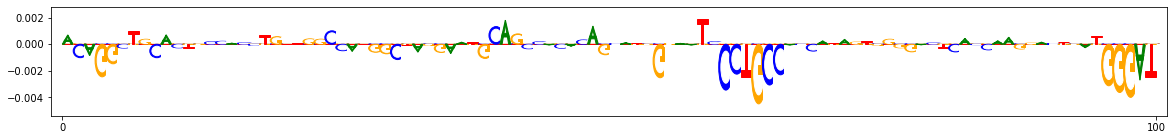

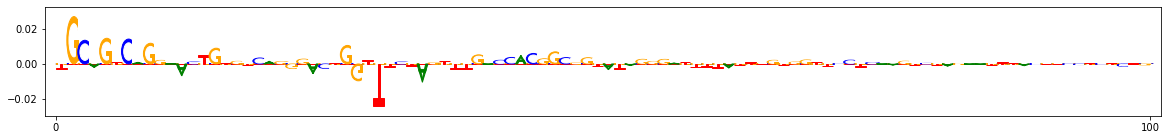

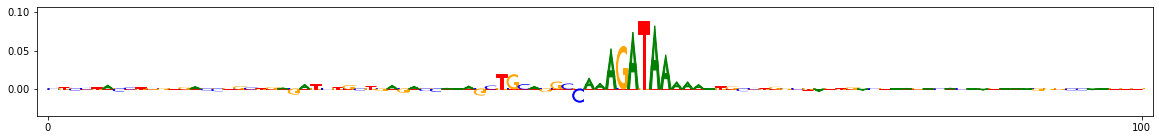

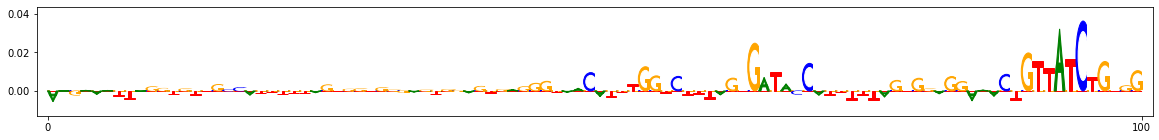

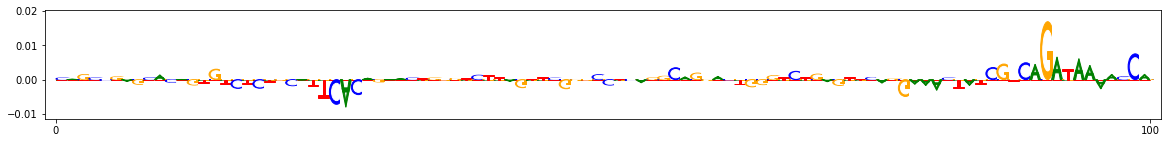

In [5]:
with h5py.File(shap_scores_path, "r") as f:
    hyp_scores = f["hyp_scores"]
    input_seqs = f["input_seqs"]
    for index in np.random.choice(hyp_scores.shape[0], size=5, replace=False):
        viz_sequence.plot_weights((hyp_scores[index] * input_seqs[index])[650:750], subticks_frequency=100)

### Plot TF-MoDISco results

Metacluster: metacluster_0 (1/2)
Pattern: pattern_0 (1/1)
--------------------------------------
969 seqlets
Sequence


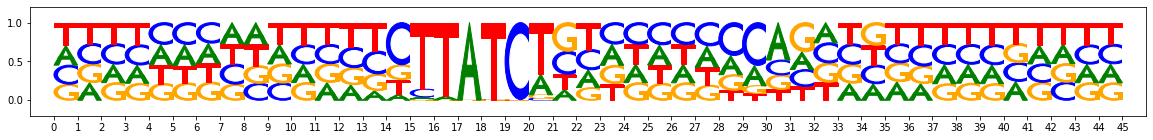

Hypothetical contributions


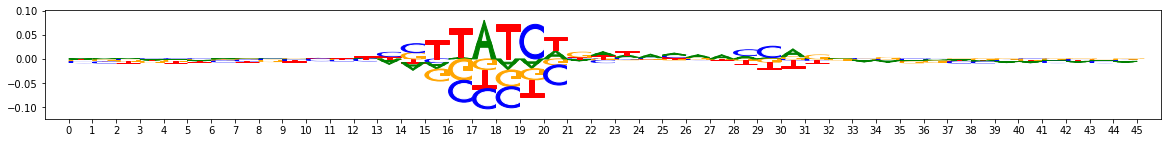

Contribution_scores


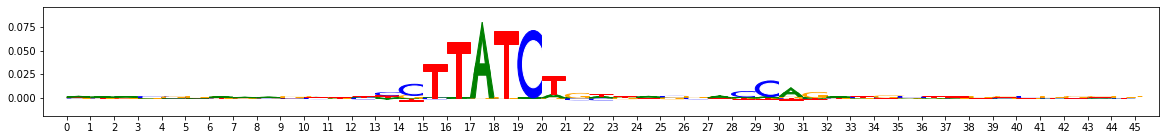

Metacluster: metacluster_1 (2/2)


In [9]:
# Plot all motifs
with h5py.File(tfm_results_path, "r") as f:
    metaclusters = f["metacluster_idx_to_submetacluster_results"]
    num_metaclusters = len(metaclusters.keys())
    for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
        metacluster = metaclusters[metacluster_key]
        print("Metacluster: %s (%d/%d)" % (metacluster_key, metacluster_i + 1, num_metaclusters))
        print("==========================================")
        patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
        num_patterns = len(patterns["all_pattern_names"][:])
        for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
            pattern_name = pattern_name.decode()
            pattern = patterns[pattern_name]
            seqlets = pattern["seqlets_and_alnmts"]["seqlets"]

            print("Pattern: %s (%d/%d)" % (pattern_name, pattern_i + 1, num_patterns))
            print("--------------------------------------")

            print("%d seqlets" % len(seqlets))
            print("Sequence")
            viz_sequence.plot_weights(pattern["sequence"]["fwd"][:])
            print("Hypothetical contributions")
            viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"][:])
            print("Contribution_scores")
            viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"][:])